In [ ]:
!pip install -U accelerate>=0.21.0
!pip install -U transformers

In [ ]:
!pip show accelerate transformers

Name: accelerate
Version: 0.31.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
---
Name: transformers
Version: 4.41.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/data4.csv", usecols=["text", "label"])
df.head()

In [ ]:
df.shape
df.info()

df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5730 entries, 0 to 5729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5730 non-null   object
 1   label   5730 non-null   object
dtypes: object(2)
memory usage: 89.7+ KB


29

<Axes: ylabel='Frequency'>

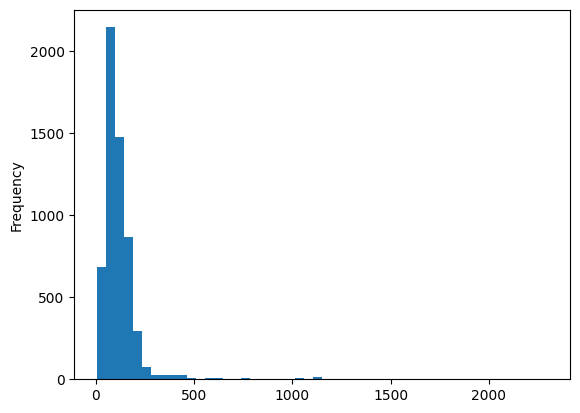

In [ ]:
df['text'].str.len().plot.hist(bins=50)

In [ ]:
df['label'] = df['label'].str.split(',')

In [ ]:
label_counts = [g for gen in df['label'] for g in gen]
pd.Series(label_counts).value_counts()

Politik                    2860
Sumber Daya Alam            634
Demografi                   555
Geografi                    519
Sosial Budaya               384
Ekonomi                     268
Pertahanan dan Keamanan     257
Ideologi                    253
Name: count, dtype: int64

In [ ]:
from sklearn.utils import resample
df_exploded = df.explode('label')

In [ ]:
label_counts = df_exploded['label'].value_counts()

In [ ]:
cap_value = int(1.5 * label_counts.median())

In [ ]:
resampled_dfs = []
for label, count in label_counts.items():
    label_df = df_exploded[df_exploded['label'] == label]
    if count > cap_value:
        resampled_dfs.append(resample(label_df, replace=False, n_samples=cap_value, random_state=42))
    else:
        resampled_dfs.append(label_df)

In [ ]:
balanced_df = pd.concat(resampled_dfs)

In [ ]:
balanced_label_counts = balanced_df['label'].value_counts()

In [ ]:
print(balanced_label_counts)
balanced_df.head()

label
Politik                    677
Sumber Daya Alam           634
Demografi                  555
Geografi                   519
Sosial Budaya              384
Ekonomi                    268
Pertahanan dan Keamanan    257
Ideologi                   253
Name: count, dtype: int64


,text,label
2302,mencerdaskan kehidupan bangsa pasangan muhaimi...,Politik
2566,nasdem pertimbangkan jalur hukum beredar hoaks...,Politik
1104,foto aktivis sosok pemimpin matang rekam jejak...,Politik
2546,muka sebelah kanan kayak gerak semoga sehat,Politik
560,cal out kali aksi kamisan pendukungnya bilang isu,Politik


In [ ]:
df = balanced_df.groupby('text')['label'].apply(list).reset_index()

In [ ]:
df['label_str'] = df['label'].apply(lambda x: ','.join(x))

In [ ]:
df = df.drop_duplicates(subset=['text', 'label_str'])

In [ ]:
df = df.drop(columns=['label_str'])

Label encoder

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
multilabel = MultiLabelBinarizer()

labels = multilabel.fit_transform(df['label']).astype('float32')

texts = df['text'].tolist()

In [ ]:
labels
texts[:5]

['1 nih garden sumber kali food industrial estate gunung regency kalteng tanggung garden kemhan langsung jokowi river bro tiati river misleading forest trsorgorgpercaya',
 '1 nih sumber rahman food factory estate jakarta gunung west kalteng bazaar tanggung kemhan jalan langsung jaya jokowi bro and tiati the misleading trsorgorgpercaya',
 '1 nrei jalan titip pikir dan gagas training program tingkat program sdm malaysia unggul selangor timur sultan danatau jaya daerah jaya kepulauanterimakasih',
 '1 peta indonesia politik lihat indonesia prab cek se gub tak jakartajadisuriah',
 '1 pindah bay ikn rezeki tan anak cucu ja mudah jakartabandung gan kabar gabung sumpek pulau malay jawa chin lihat kembang ikn UNK semangat lanjut di bangun dan terimakasih']

Model building

In [ ]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2, random_state=42)

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]),
problem_type="multi_label_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
labels[0]

array([0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# Lets build custom dataset
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

In [ ]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [ ]:
# val_dataset[0]

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss, accuracy_score, balanced_accuracy_score
from transformers import EvalPrediction

# Metrics calculation
def multi_labels_metrics(predictions, labels, threshold=0.3):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average='macro')
    hamming = hamming_loss(y_true, y_pred)

    # Calculate balanced accuracy for each label separately and then average them
    balanced_accuracies = []
    for i in range(y_true.shape[1]):
        balanced_accuracies.append(balanced_accuracy_score(y_true[:, i], y_pred[:, i]))
    balanced_acc = np.mean(balanced_accuracies)

    metrics = {
        "roc_auc": roc_auc,
        "hamming_loss": hamming,
        "f1": f1,
        "balanced_accuracy": balanced_acc
    }

    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_labels_metrics(predictions=preds, labels=p.label_ids)
    return result

In [ ]:
pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
per_device_train_batch_size=8,
per_device_eval_batch_size=8,
output_dir = 'content/drive/MyDrive/BDCresult',
num_train_epochs=5,
save_steps=250,
save_total_limit=2
)

trainer = Trainer(model=model,
args=args,
train_dataset=train_dataset,
eval_dataset = val_dataset,
compute_metrics=compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
500,0.282300
1000,0.150700
1500,0.093500


TrainOutput(global_step=1765, training_loss=0.15826378625107893, metrics={'train_runtime': 11276.0049, 'train_samples_per_second': 1.249, 'train_steps_per_second': 0.157, 'total_flos': 466500738447360.0, 'train_loss': 0.15826378625107893, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.37942224740982056,
 'eval_roc_auc': 0.6946728150614365,
 'eval_hamming_loss': 0.10560344827586207,
 'eval_f1': 0.4586211590186473,
 'eval_balanced_accuracy': 0.6946728150614365,
 'eval_runtime': 79.3925,
 'eval_samples_per_second': 4.383,
 'eval_steps_per_second': 0.554,
 'epoch': 5.0}

In [ ]:
trainer.save_model("hasilbdc")

In [ ]:
import pickle
with open("multi-label-binarizer.pkl", "wb") as f:
  pickle.dump(multilabel, f)

In [ ]:
!zip -r distilbert.zip "/content/drive/MyDrive/hasilbdc"

updating: content/drive/MyDrive/hasilbdc/ (stored 0%)
updating: content/drive/MyDrive/hasilbdc/config.json (deflated 54%)
updating: content/drive/MyDrive/hasilbdc/model.safetensors (deflated 8%)
updating: content/drive/MyDrive/hasilbdc/training_args.bin (deflated 51%)


Prediction

In [ ]:
text = "Kontrak terbuka Ganjar Pranowo adalah cermin dari kepedulian untuk kita semua. Yuk, bersama jaga kedaulatan pangan!#JNK #GanjarMahfudRebound #GanjarPranowoPilihanUmat https://t.co/SPFC60u1Eg"

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('Politik',)]

In [ ]:
preds.reshape(1,-1)

array([[0., 0., 0., 0., 0., 1., 0., 0.]])

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import numpy as np
import pickle

In [ ]:
dataunlabeled = "drive/MyDrive/dataset_unlabeled_penyisihan_bdc_2024.csv"

In [ ]:
dataset_unlabeled = pd.read_csv(dataunlabeled, sep=';')

In [ ]:
dataset_unlabeled.head()

,IDText,Text
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...


In [ ]:
def predict(text, model, tokenizer, max_len=512):
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_len)
    encoding = {k: v.to(model.device) for k, v in encoding.items()}
    outputs = model(**encoding)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(outputs.logits).detach().cpu().numpy()
    return probs

In [ ]:
# Predict labels for each text in the new dataset
predictions = []
for text in dataset_unlabeled['Text']:
    probs = predict(text, model, tokenizer)
    max_prob_idx = np.argmax(probs, axis=1)
    label = multilabel.classes_[max_prob_idx][0]  # Ensure only one label is selected
    predictions.append(label)

In [ ]:
# Add predictions to the DataFrame
dataset_unlabeled['Label'] = predictions

In [ ]:
# Save the results to a new CSV file
output_path = "/content/drive/MyDrive/prediksibdc.csv"
dataset_unlabeled.to_csv(output_path, index=False)

In [ ]:
print(f"Results saved to {output_path}")

Results saved to /content/drive/MyDrive/prediksibdc.csv


predict dataset